In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim   
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [31]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
# torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [33]:
train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('/files/', train=True, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  datasets.MNIST('/files/', train=False, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

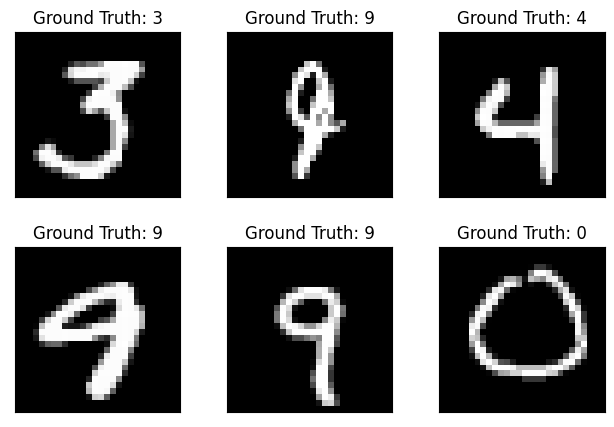

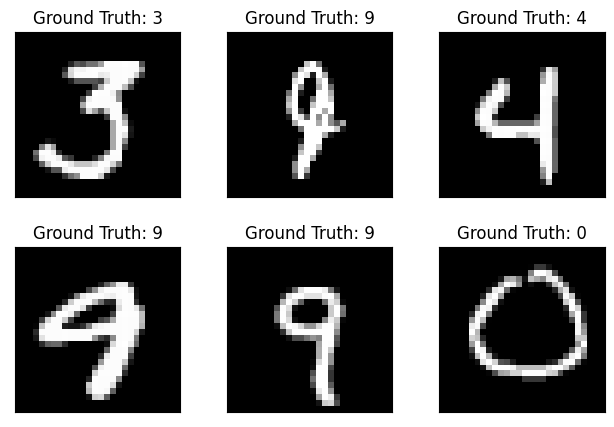

In [34]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, device=device)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, device=device)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50, device=device)
        self.fc2 = nn.Linear(50, 10, device=device)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [51]:
network = Net()
# optimizer = optim.SGD(network.parameters(), lr=learning_rate,
#                       momentum=momentum)

network = network.to(device=device)

optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [52]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [53]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.to(device=device)
    target = target.to(device=device)
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

    # loss = loss.to(device='cpu')
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [54]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device=device)
      target = target.to(device=device)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [55]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\prave\AppData\Local\Temp\ipykernel_23588\3014975092.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.282716
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.911997
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.678421
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.670092
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.272084
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.815245
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.905282
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.281043
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.856438
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.751021
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.811970
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.178945
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.572067
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.676133
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.854143
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.473110
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.846946
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.687100
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.553694
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.987258
Train Epoch: 1 [12800/60000 (

c:\ProgramData\Anaconda3\envs\pytorchenv3.8\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1269, Accuracy: 9599/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.705259
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.344123
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.628897
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.651945
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.438607
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.512447
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.562236
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.535902
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.633283
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.266991
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.756056
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.509383
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.593654
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.691175
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.276779
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.441861
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.875161
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.358817
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.720852
Train Epoch: 2 [12160

In [71]:
print(len(train_counter), len(train_losses))
print(len(test_counter), len(test_losses))

282 282
4 3


ValueError: x and y must be the same size

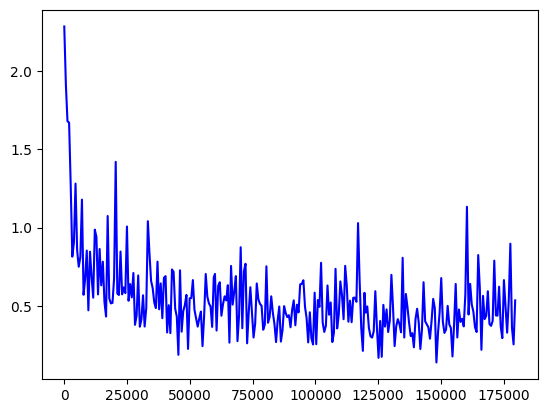

In [56]:

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [65]:
with torch.no_grad():
    example_data = example_data.to(device=device)
    output = network(example_data)

C:\Users\prave\AppData\Local\Temp\ipykernel_23588\3014975092.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


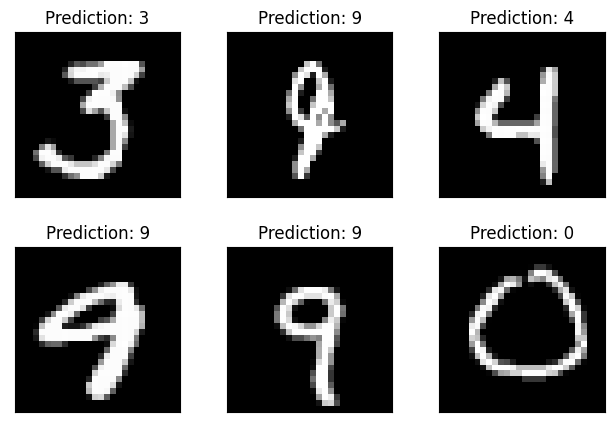

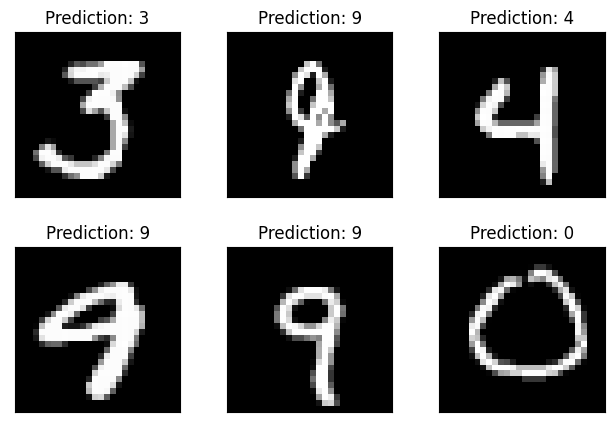

In [67]:
fig = plt.figure()
example_data = example_data.cpu()
output = output.cpu()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig